In [402]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

import rasterio

import warnings
warnings.filterwarnings("ignore")

In [405]:
# Define torch dataset Class
class Dataset(Dataset):
    def __init__(self,folder_path,dataset_file,sen2_amount=1,sen2_tile="all"):
        
        # define filepaths
        self.folder_path = folder_path
        # read file
        self.df = pd.read_pickle(dataset_file)
        # set amount of sen2 pictures that should be returned
        self.sen2_amount = sen2_amount
        
        # filter for sen2 tile
        if sen2_tile!="all":
            self.df = self.df[self.df["sen2_tile"]==sen2_tile]
            
        # clear up DF
        self.df = self.df[self.df["sen2_no"]>2]
        try:
            self.df = self.df.drop(labels=["level_0"], axis=1)
        except KeyError:
            pass
        self.df = self.df.reset_index()
        
    def __len__(self):
        """
        Returns length of data
        """
        return(len(self.df))
    
 
    def moment_matching(self,sen2,spot6):    
        """
        {[spot6 - mean(spot6)] / stdev(spot6) } * stdev(sen2) 
        + mean(sen2)
        """

        c = 0
        for channel_sen,channel_spot in zip(sen2,spot6):
            c +=1
            #calculate stats
            sen2_mean   = np.mean(channel_sen)
            spot6_mean  = np.mean(channel_spot)
            sen2_stdev  = np.std(channel_sen)
            spot6_stdev = np.std(channel_spot)
            
            # calculate moment per channel
            channel_result = (((channel_spot - spot6_mean) / spot6_stdev) * sen2_stdev) + sen2_mean
            
            # stack channels to single array
            if c==1:
                result = channel_result
            else:
                result = np.dstack((result,channel_result))
            # transpose back to Cx..
            
        result = result.transpose((2,0,1))   
        return(result)
        
        
        
    
    def __getitem__(self,idx):
        
        current = self.df.iloc[idx]
        spot6_file = current["spot6_filenames"]
        sen2_files = current["sen2_filenames"]
        other_valid_acq = current["other_valid_acq"]        

        """ORDER SEN2 DATES"""
        ordered_sen2 = []
        sen2_clean = {}
        for i in sen2_files:
            sen2_clean[i[:61]] = i
        for i in sorted(other_valid_acq):
            s = other_valid_acq[i][1][:61]
            if s in sen2_clean:
                ordered_sen2.append(sen2_clean[s])

        
        """READ SPOT6"""
        spot6 = rasterio.open(self.folder_path+"y/"+spot6_file).read()

    
        """READ SEN2 SERIES"""
        # read first file
        sen2 = rasterio.open(self.folder_path+"x/"+ordered_sen2[0]).read()
        
        if self.sen2_amount>1:
            # read following sen2 and stack
            count=1
            for i in ordered_sen2[1:]:
                # read file as array
                sen2_following = rasterio.open(self.folder_path+"x/"+ordered_sen2[count]).read()
                # stack to previous images
                sen2 = np.concatenate([sen2, sen2_following])

                # break if all wanted files loaded
                count=count+1
                if count==self.sen2_amount:
                    break
            # if final count not yet reached, repeat last chip until enough are there
            while count<self.sen2_amount:
                sen2 = np.concatenate([sen2, sen2_following])
                count=count+1
                
        
        def minmax(img):
            return(img-np.min(img,axis=(0,1)) ) / (np.max(img,axis=(0,1))-np.min(img,axis=(0,1)))
        
        #_ = plt.hist(np.ndarray.flatten(spot6), bins=100)
        #plt.title("hist. Spot6 before")
        #plt.show()
        
        # perform radiometric transform to sen2
        spot6 = self.moment_matching(sen2,spot6)
        print(spot6.shape,sen2.shape)
        sen2_im,spot6_im = sen2.transpose(1,2,0),spot6.transpose(1,2,0)
        print(spot6_im.shape,sen2_im.shape)
        
        print(np.min(spot6_im),np.min(sen2_im))
        spot6_im[spot6_im <0] = 0
        sen2_im[sen2_im <0] = 0
        print(np.min(spot6_im),np.min(sen2_im))
        
        # stretch to 0..1
        spot6_im = spot6_im/10000.0
        sen2_im  = sen2_im/10000.0
        
        plt.imshow(minmax(spot6_im))
        plt.title="spot6"
        plt.show()
        plt.imshow(minmax(sen2_im))
        plt.title="sen2"
        plt.show()


        # transform to tensor
        sen2  = torch.from_numpy(sen2)
        spot6 = torch.from_numpy(spot6)
        sen2 = sen2.float()
        spot6 = spot6.float()
        
        # define transformer
        #transform_spot = transforms.Compose([transforms.Normalize(mean=[479.0, 537.0, 344.0], std=[430.0, 290.0, 229.0]) ])
        # dynamically define transform to reflect shape of tensor
        #trans_mean,trans_std = [78.0, 91.0, 62.0]*self.sen2_amount,[36.0, 28.0, 30.0]*self.sen2_amount
        #transform_sen = transforms.Compose([transforms.Normalize(mean=trans_mean, std= trans_std)])
        # perform transform
        #sen2  = transform_sen(sen2)
        #spot6 = transform_spot(spot6)
        
        # return result
        return(spot6,sen2)


In [508]:
dataset = Dataset("data_f4/","data_f4_pkls/df_saved_images.pkl",sen2_amount=1,sen2_tile="all")
loader  = DataLoader(dataset,batch_size=64, shuffle=True, num_workers=0,pin_memory=True,
                    drop_last=True,prefetch_factor=2)

# Time difference distribution

In [509]:
time_dif_1 = []
time_dif_2 = []
time_dif_3 = []
time_dif_4 = []
for i in dataset.df["other_valid_acq"]:
    time_dif_1.append(sorted(i.keys())[0])
    time_dif_2.append(sorted(i.keys())[1])
    time_dif_3.append(sorted(i.keys())[2])
    time_dif_4.append(sorted(i.keys())[3])
time_dif = pd.DataFrame(list(zip(time_dif_1,time_dif_2,time_dif_3,time_dif_4)),columns=["closest","2nd closest","3rd closest","4th closest"])

In [510]:
time_dif

,closest,2nd closest,3rd closest,4th closest
0,1,14,17,33
1,1,14,17,33
2,1,14,17,33
3,1,14,17,33
4,1,14,17,33
...,...,...,...,...
45375,1,14,29,64
45376,1,14,29,64
45377,1,14,29,64
45378,1,14,29,64


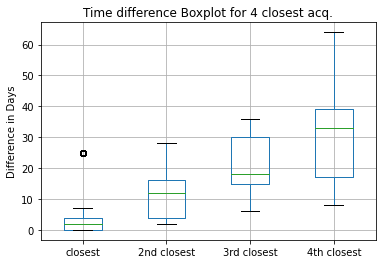

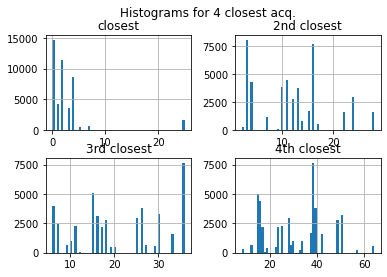

In [518]:
ax = time_dif.boxplot()
ax.set_title("Time difference Boxplot for 4 closest acq.")
ax.set_ylabel("Difference in Days")

plt.show()


time_dif.hist(bins=60)
plt.suptitle("Histograms for 4 closest acq.")
plt.show()


In [516]:
time_dif

,closest,2nd closest,3rd closest,4th closest
0,1,14,17,33
1,1,14,17,33
2,1,14,17,33
3,1,14,17,33
4,1,14,17,33
...,...,...,...,...
45375,1,14,29,64
45376,1,14,29,64
45377,1,14,29,64
45378,1,14,29,64
